# Plot leptonJets multiplicity of all events.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor

In [3]:
import json
datasets = json.load(open('Samples/signal_4mu.json'))
datasets.keys()

dict_keys(['mXX-1000_mA-0p25_lxy-300', 'mXX-1000_mA-0p8_lxy-300', 'mXX-1000_mA-1p2_lxy-300', 'mXX-1000_mA-2p5_lxy-300', 'mXX-1000_mA-5_lxy-300', 'mXX-100_mA-0p25_lxy-300', 'mXX-100_mA-0p8_lxy-300', 'mXX-100_mA-1p2_lxy-300', 'mXX-100_mA-2p5_lxy-300', 'mXX-100_mA-5_lxy-300', 'mXX-150_mA-0p25_lxy-300', 'mXX-150_mA-0p8_lxy-300', 'mXX-150_mA-1p2_lxy-300', 'mXX-150_mA-2p5_lxy-300', 'mXX-150_mA-5_lxy-300', 'mXX-200_mA-0p25_lxy-300', 'mXX-200_mA-0p8_lxy-300', 'mXX-200_mA-1p2_lxy-300', 'mXX-200_mA-2p5_lxy-300', 'mXX-200_mA-5_lxy-300', 'mXX-500_mA-0p25_lxy-300', 'mXX-500_mA-0p8_lxy-300', 'mXX-500_mA-1p2_lxy-300', 'mXX-500_mA-2p5_lxy-300', 'mXX-500_mA-5_lxy-300', 'mXX-800_mA-0p25_lxy-300', 'mXX-800_mA-0p8_lxy-300', 'mXX-800_mA-1p2_lxy-300', 'mXX-800_mA-2p5_lxy-300', 'mXX-800_mA-5_lxy-300', 'mXX-1000_mA-0p25_lxy-0p3', 'mXX-100_mA-5_lxy-0p3'])

In [4]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "signal")
        multiplicity_axis = hist.Bin("multiplicity", r"#leptonJets/event", 12, 0, 12)
        
        self._accumulator = processor.dict_accumulator({
            'multiplicity': hist.Hist("Counts", dataset_axis, multiplicity_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        output['multiplicity'].fill(dataset=dataset, multiplicity=leptonjets.counts)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=6, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 160/160 [00:18<00:00,  8.86items/s]


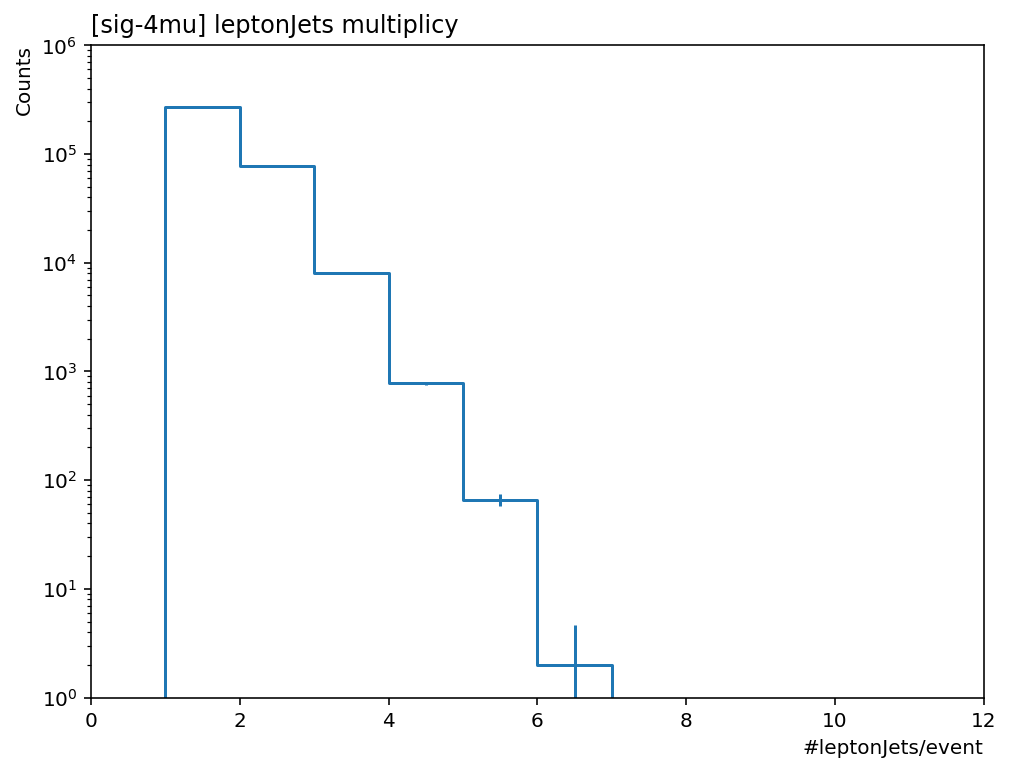

In [6]:
leptontjetmul = output['multiplicity'].project('dataset')

fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(leptontjetmul, ax=ax)

ax.set_ylim([1, 1e6])
ax.set_yscale('log')

ax.set_title('[sig-4mu] leptonJets multiplicy', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

---